In [1]:
cd wrkDir/stampSim/HSC-like

/lustre2/work/xiangchong.li/massMapSim/stampSim/HSC-like


In [2]:
%pylab inline
import os
from pixel3D import cartesianGrid3D
from sparseBase import massmapSparsityTask
from configparser import ConfigParser

hdir='./process-equalNum-test2'
configName  =   os.path.join(hdir,'config.ini')
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)

Populating the interactive namespace from numpy and matplotlib


In [242]:
deltaTrue=100   # input signal's magnitude
zlt=0.234
izlo=np.where((zlt>gridInfo.zlbound[:-1])&(zlt<=gridInfo.zlbound[1:]))[0][0]

C_LIGHT=2.99792458e8        # m/s
GNEWTON=6.67428e-11         # m^3/kg/s^2
KG_PER_SUN=1.98892e30       # kg/M_solar
M_PER_PARSEC=3.08568025e16  # m/pc

def four_pi_G_over_c_squared():
    # = 1.5*H0^2/roh_0/c^2
    # We want it return 4piG/c^2 in unit of Mpc/M_solar
    # in unit of m/kg
    fourpiGoverc2 = 4.0*np.pi*GNEWTON/(C_LIGHT**2)
    # in unit of pc/M_solar
    fourpiGoverc2 *= KG_PER_SUN/M_PER_PARSEC
    # in unit of Mpc/M_solar
    fourpiGoverc2 /= 1.e6
    return fourpiGoverc2

kl =   np.zeros(gridInfo.nz)
mask=  (zlt<gridInfo.zcgrid)
kl[mask] =   gridInfo.cosmo.Da(zlt,gridInfo.zcgrid[mask])*gridInfo.cosmo.Da(0.,zlt)\
    /gridInfo.cosmo.Da(0.,gridInfo.zcgrid[mask])
kl*=four_pi_G_over_c_squared()
rhoM_ave=gridInfo.cosmo.rho_m(zlt)
DaBin=gridInfo.cosmo.Da(gridInfo.zlbound[izlo],gridInfo.zlbound[izlo+1])
gammat=np.matrix(kl*rhoM_ave*DaBin*deltaTrue).T
#gammat=np.matrix(lk[:,izlo]).T*deltaTrue

# Lensing Kernel

shape of lensing kernel:  (10, 20)


(-0.5, 2.0)

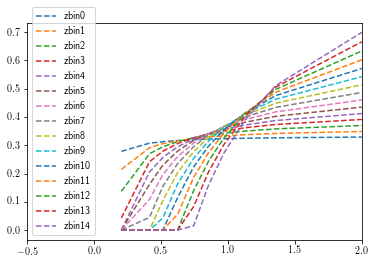

In [235]:
lk=gridInfo.lensing_kernel()
lknorm=np.sqrt(np.sum(lk**2.,axis=0))
lk1=lk/lknorm[None,:]
print('shape of lensing kernel: ',lk1.shape)
for izl in range(0,15):
    norm1=np.sqrt(np.sum(lk1[:,izl]**2.))
    plt.plot(gridInfo.zcgrid,lk1[:,izl]/norm1,'--',label='zbin%d' %izl)
plt.legend(loc='lower left')
plt.xlim(-.5,2.)

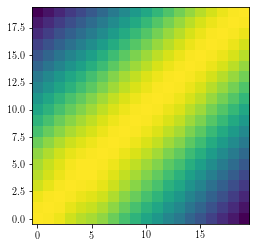

In [217]:
covariance=np.zeros((lk1.shape[1],lk1.shape[1]))
for i in range(lk1.shape[1]):
    for j in range(i,lk1.shape[1]):
        covariance[i,j]=np.sum(lk1[:,i]*lk1[:,j])
        covariance[j,i]=covariance[i,j]
plt.imshow(covariance,origin='lower left')

In [218]:
nstep=1
A=np.matrix(lk1[:,::nstep])
lknormA=lknorm[::nstep]
if False:
    print('The trasfrom matrix is \n',A)
print(A.shape)
ndim=A.shape[0] # source redshift bins
if False:
    np.linalg.inv(A)*gammat2

(10, 20)


# 2. Sparsity Regression
We then consider the $\chi^2$ fitting with sparsity reularization.
$$\rm{min}{(||\vec{\gamma}-\mathbf{A}\vec{x}||_2^2+\lambda \sigma(x) |\vec{x}|^1_1}).$$
The estimated $x$ should be
$$\vec{x}^{(n+1)}=S_\lambda(\vec{x}^{(n)}+\mathbf{A}^T (\vec{\gamma}-\mathbf{A}\vec{x}^{(n)})),$$
where $S_\lambda$ is the soft-thresholding function.

In [258]:
def soft_thresholding(dum,thresholds):
    # Standard Threshold Function
    return np.multiply(np.sign(dum),np.maximum(np.abs(dum)-thresholds,0.))

def solve_lasso(B,d,lbd,nadp=2):
    x=np.matrix(np.zeros(B.shape[1])).T
    mu=.05
    tn=1
    Xp0=x
    BT=B.T
    for i in range(8000):
        g=BT.dot((d-B.dot(x)))
        tmp=x+mu*g
        tmp=soft_thresholding(tmp,np.matrix(mu*lbd).T)
        tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
        ratio= (tn-1.)/tnTmp
        x    = tmp+(ratio*(tmp-Xp0))
        tn   = tnTmp
        Xp0  = tmp
        
    for j in range(nadp):
        tn=1
        Xp0=x
        xt=np.abs(np.array(x.T)[0])
        for i in range(800):
            g=BT.dot((d-B.dot(x)))
            tmp=x+mu*g
            tmp=soft_thresholding(tmp,np.matrix(mu*lbd/xt).T)
            tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
            ratio= (tn-1.)/tnTmp
            x    = tmp+(ratio*(tmp-Xp0))
            tn   = tnTmp
            Xp0  = tmp
    return x

S/N of the input delta: 128.420
S/T of the input delta: 2568.394


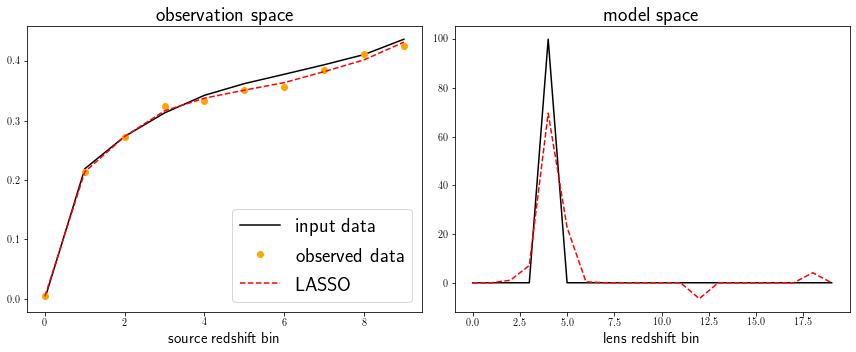

In [259]:
lbd=.05          # sparse parameter
stdnoiUNorm=stdnoi/lknormA
SNR=deltaTrue/stdnoiUNorm[int(izlo//nstep)]

print("S/N of the input delta: %.3f" %SNR)
print("S/T of the input delta: %.3f" %(SNR/lbd) )

gamma=gammat+np.matrix(np.random.randn(ndim)*sigma_noi).T
x_est=solve_lasso(A,gamma,lbd*stdnoi,0)
x_est2=np.divide(x_est.T,lknormA).T

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.set_title('observation space',fontsize=20)
ax.plot(gammat,label='input data',color='black')
ax.plot(gamma,'o',label='observed data',color='orange')
ax.plot(A*x_est,ls='--',label='LASSO',color='red')
#ax.plot(A*x_estA,ls='-.',label='Adaptive LASSO',color='blue')
ax.legend(fontsize=20)
ax.set_xlabel('source redshift bin',fontsize=15)

ax=fig.add_subplot(1,2,2)
ax.set_title('model space',fontsize=20)
xin=np.zeros(A.shape[1])
xin[int(izlo//nstep)]=deltaTrue
ax.plot(xin,label='input data',color='black')
ax.plot(x_est2,label='LASSO',ls='--',color='red')
#ax.plot(x_estA2,label='Adaptive LASSO',ls='-.',color='blue')
ax.set_xlabel('lens redshift bin',fontsize=15)

plt.tight_layout()

In [149]:
sigma_noi=0.008
nsim=200
std_ext=np.zeros((nsim,A.shape[1]))
for i in range(nsim):
    d= np.matrix(np.random.randn(ndim)*sigma_noi).T
    std_ext[i]=np.array(A.T.dot(d).T)[0]
stdnoi=np.std(std_ext,axis=0)

lbd=2.5          # sparse parameter
stdnoiUNorm=stdnoi/lknormA
SNR=deltaTrue/stdnoiUNorm[int(izlo//nstep)]

print("S/N of the input delta: %.3f" %SNR)
print("S/T of the input delta: %.3f" %(SNR/lbd) )
gammat=np.matrix(lk[:,izlo]).T*deltaTrue

In [159]:
for i in range(1):
    gamma=gammat+np.matrix(np.random.randn(ndim)*sigma_noi).T
    x_est=solve_lasso(A,gamma,lbd*stdnoi,0)
    x_est2=np.divide(x_est.T,lknormA).T
    
    x_estA=solve_lasso(A,gamma,lbd*stdnoi,2)
    x_estA2=np.divide(x_estA.T,lknormA).T

S/N of the input delta: 128.420
S/T of the input delta: 51.368


/data1b/work/xiangchong.li/superonionMaster/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


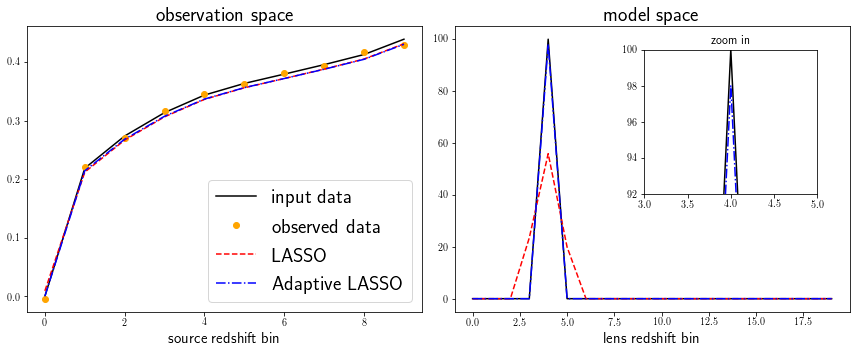

In [170]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.set_title('observation space',fontsize=20)
ax.plot(gammat,label='input data',color='black')
ax.plot(gamma,'o',label='observed data',color='orange')
ax.plot(A*x_est,ls='--',label='LASSO',color='red')
ax.plot(A*x_estA,ls='-.',label='Adaptive LASSO',color='blue')
ax.legend(fontsize=20)
ax.set_xlabel('source redshift bin',fontsize=15)

ax=fig.add_subplot(1,2,2)
ax.set_title('model space',fontsize=20)
xin=np.zeros(A.shape[1])
xin[int(izlo//nstep)]=deltaTrue
ax.plot(xin,label='input data',color='black')
ax.plot(x_est2,label='LASSO',ls='--',color='red')
ax.plot(x_estA2,label='Adaptive LASSO',ls='-.',color='blue')
ax.set_xlabel('lens redshift bin',fontsize=15)

ax2 = plt.axes([0.75, 0.45, 0.2, 0.4])
ax2.set_title('zoom in',fontsize=12)
ax2.set_ylim(92,100)
ax2.set_xlim(izlo-1,izlo+1)
ax2.plot(xin,label='input data',color='black')
ax2.plot(x_est2,label='LASSO',ls='--',color='red')
ax2.plot(x_estA2,label='Adaptive LASSO',ls='-.',color='blue')

plt.tight_layout()